<h1><center><b> Improving the quality of life and development in a large city</b></center></h1>


The city of São Paulo is divided into districts (or neighborhoods). Let's compare the central and 
peripheral districts with regard to nearby venues, the human development index, average 
monthly salaries and population. Which districts deserve greater attention from the authorities?

## Table of contents

0.Prerequisites to run this notebook <br/>
1.Collecting data about population <br/>
2.Collecting data about Human Development Index <br/>
3.Looking form districts coordinates <br/>
4.Exploring districts' surroundings <br/>
5.Collecting data about salaries<br/>
6.Clustering and Visualizing Folium Maps <br/>

## 0.Prerequisites to run this notebook

Before run this notebook, complete the following cell with your Foursquare credentials:

In [40]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)



Your credentails:
CLIENT_ID: 
CLIENT_SECRET:



## 1.Collecting data about population

We will use Beautiful Soup to scrap data from Wikipedia:


In [2]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

page = requests.get('https://pt.wikipedia.org/wiki/Lista_dos_distritos_de_S%C3%A3o_Paulo_por_popula%C3%A7%C3%A3o')

# define the dataframe columns
column_names = ['District', 'Population2010']
# instantiate the dataframe
saoPauloDf = pd.DataFrame(columns=column_names)

soup = BeautifulSoup(page.text, 'html.parser')
soup.prettify()

trs = soup.findAll('tr')

for tr in trs:
    tds = tr.findAll('td')
    if len(tds) == 4:
        col1 = tds[1].text.replace("\n","")
        col2 = int(tds[2].text.replace(".",""))
        saoPauloDf = saoPauloDf.append({'District': col1, 'Population2010':col2}, ignore_index= True)

saoPauloDf.head()        


,District,Population2010
0,Grajaú,444593
1,Sapopemba,296042
2,Jardim Ângela,291798
3,Brasilândia,280069
4,Capão Redondo,275230


## 2.Collecting data about Human Development Index

Let us scrap the page in Wikipedia:

In [3]:
page = requests.get('https://pt.wikipedia.org/wiki/Lista_dos_distritos_de_S%C3%A3o_Paulo_por_%C3%8Dndice_de_Desenvolvimento_Humano')

soup = BeautifulSoup(page.text, 'html.parser')
soup.prettify()


column_names = ['District', 'Human Development Index', 'Classification']
# instantiate the dataframe
saoPauloHDIDf = pd.DataFrame(columns=column_names)

element = soup.find('span', {'id':'Desenvolvimento_humano_muito_elevado'}).parent.findNext('table').findAll('table')

for tr in element[0].findAll('tr'):
    tds = tr.findAll('td')
    if len(tds) == 3:
        col1 = tds[1].text.replace("\n","")
        col2 = float(tds[2].text.replace(",",".").replace("\n",""))
        col3 = 'very high'
        saoPauloHDIDf = saoPauloHDIDf.append({'District': col1, 'Human Development Index': col2, 'Classification':col3}, ignore_index= True)

for tr in element[1].findAll('tr'):
    tds = tr.findAll('td')
    if len(tds) == 3:
        col1 = tds[1].text.replace("\n","")
        col2 = float(tds[2].text.replace(",",".").replace("\n",""))
        col3 = 'very high'
        saoPauloHDIDf = saoPauloHDIDf.append({'District': col1, 'Human Development Index': col2, 'Classification':col3}, ignore_index= True)

element = soup.find('span', {'id':'Desenvolvimento_humano_elevado'}).parent.findNext('table').findAll('table')

for tr in element[0].findAll('tr'):
    tds = tr.findAll('td')
    if len(tds) == 3:
        col1 = tds[1].text.replace("\n","")
        col2 = float(tds[2].text.replace(",",".").replace("\n",""))
        col3 = 'high'
        saoPauloHDIDf = saoPauloHDIDf.append({'District': col1, 'Human Development Index': col2, 'Classification':col3}, ignore_index= True)

for tr in element[1].findAll('tr'):
    tds = tr.findAll('td')
    if len(tds) == 3:
        col1 = tds[1].text.replace("\n","")
        col2 = float(tds[2].text.replace(",",".").replace("\n",""))
        col3 = 'high'
        saoPauloHDIDf = saoPauloHDIDf.append({'District': col1, 'Human Development Index': col2, 'Classification':col3}, ignore_index= True)

element = soup.find('span', {'id':'Desenvolvimento_humano_médio'}).parent.findNext('table').findAll('table')

for tr in element[0].findAll('tr'):
    tds = tr.findAll('td')
    if len(tds) == 3:
        col1 = tds[1].text.replace("\n","")
        col2 = float(tds[2].text.replace(",",".").replace("\n",""))
        col3 = 'medium'
        saoPauloHDIDf = saoPauloHDIDf.append({'District': col1, 'Human Development Index': col2, 'Classification':col3}, ignore_index= True)

for tr in element[1].findAll('tr'):
    tds = tr.findAll('td')
    if len(tds) == 3:
        col1 = tds[1].text.replace("\n","")
        col2 = float(tds[2].text.replace(",",".").replace("\n",""))
        col3 = 'medium'
        saoPauloHDIDf = saoPauloHDIDf.append({'District': col1, 'Human Development Index': col2, 'Classification':col3}, ignore_index= True)
        
        
saoPauloHDIDf.head()



,District,Human Development Index,Classification
0,Moema,0.981,very high
1,Pinheiros,0.980,very high
2,Perdizes,0.977,very high
3,Jardim Paulista,0.975,very high
4,Alto de Pinheiros,0.972,very high


Let us merge these dataframes:

In [4]:
saoPauloDf = pd.merge(saoPauloDf, saoPauloHDIDf, on='District')        
saoPauloDf.head()

,District,Population2010,Human Development Index,Classification
0,Grajaú,444593,0.754,medium
1,Sapopemba,296042,0.786,medium
2,Jardim Ângela,291798,0.750,medium
3,Brasilândia,280069,0.769,medium
4,Capão Redondo,275230,0.782,medium


## 3.Looking for districts coordinates

First let us save the data collected till now:

In [5]:
# uncomment to save
# I have already saved it and modified
# saoPauloDf.to_csv('saoPauloDistricts.csv')


And I have completed csv file looking for districts'coordinates in Google maps

In [6]:
df = pd.read_csv('saoPauloDistricts.csv')
df.head()

,District,Population2010,Human Development Index,Classification,Latitude,Longitude
0,Grajaú,444593,0.754,medium,-23.771911,-46.669070
1,Sapopemba,296042,0.786,medium,-23.573739,-46.524185
2,Jardim Ângela,291798,0.750,medium,-23.700988,-46.769102
3,Brasilândia,280069,0.769,medium,-23.470400,-46.689832
4,Capão Redondo,275230,0.782,medium,-23.668870,-46.769991


## 4.Exploring districts' surroundings

And we will modify the function defined in laboratory in week 3 to search for some categories venues (libraries, schools, transports, etc) in São Paulo districts:

In [7]:
LIMIT = 50
radius=1000

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

address = 'São Paulo, SP'
geolocator = Nominatim(user_agent="sp_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of São Paulo are {}, {}.'.format(latitude, longitude))


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        library = '4bf58dd8d48988d12f941735'
        medical_center = '4bf58dd8d48988d104941735'
        non_profit='50328a8e91d4c4b30a586d6c'
        school='4bf58dd8d48988d13b941735'
        bus_station='4bf58dd8d48988d1fe931735'
        train_station='4bf58dd8d48988d129951735'
        metro_station='4bf58dd8d48988d1fd931735'
        child_care='5744ccdfe4b0c0459246b4c7'
        outdoor_recreation='4d4b7105d754a06377d81259'
        categories=library+','+medical_center+','+non_profit+','+school+','+bus_station+','+train_station +','+metro_station +','+child_care+','+outdoor_recreation
        # type your answer here
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius,LIMIT, categories)
        
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


The geograpical coordinate of São Paulo are -23.5506507, -46.6333824.


And replicate process to cluster districts by venues categories:

In [8]:

df = pd.read_csv('saoPauloDistricts.csv')
saopaulo_venues = getNearbyVenues(names=df['District'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
saopaulo_onehot = pd.get_dummies(saopaulo_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
saopaulo_onehot['District'] = saopaulo_venues['District'] 
# move neighborhood column to the first column
fixed_columns = [saopaulo_onehot.columns[-1]] + list(saopaulo_onehot.columns[:-1])
saopaulo_onehot = saopaulo_onehot[fixed_columns]

saopaulo_grouped = saopaulo_onehot.groupby('District').mean().reset_index()

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['District']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = saopaulo_grouped['District']
for ind in np.arange(saopaulo_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(saopaulo_grouped.iloc[ind, :], num_top_venues)

# set number of clusters
kclusters = 5
saopaulo_grouped_clustering = saopaulo_grouped.drop('District', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(saopaulo_grouped_clustering)
# check cluster labels generated for each row in the dataframe

district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
saopaulo_merged = df
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
saopaulo_merged = saopaulo_merged.join(district_venues_sorted.set_index('District'), on='District')
saopaulo_merged.dropna(inplace=True)


And show the venues clusters in the map:

In [9]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(saopaulo_merged['Latitude'], 
saopaulo_merged['Longitude'], saopaulo_merged['District'], 
saopaulo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

## 5.Collecting data about salaries

Scraping data and merging to Sao Paulo dataframe:

In [10]:
import requests
from bs4 import BeautifulSoup

page = requests.get('https://g1.globo.com/sao-paulo/noticia/media-de-salario-em-sp-vai-de-r-12-mil-em-marsilac-a-r-10-mil-no-campo-belo.ghtml')

soup = BeautifulSoup(page.text, 'html.parser')
soup.prettify()

# define the dataframe columns
column_names = ['District', 'Average Monthly Wage R$', 'Average Monthly Wage U$']
# instantiate the dataframe
salariesDf = pd.DataFrame(columns=column_names)

txDolar=3.3 #value for conversion in October/2017

trs = soup.findAll('tr')

for tr in trs:
    tds = tr.findAll('td')
    if len(tds) == 2 and tds[0].text != 'Distrito':
        col0 = tds[0].text
        col1 = float(tds[1].text.replace(".","").replace(",",".").replace('R$',""))
        if col0 == 'Ermelino Matarazzo': #there is a type error in page
            col1 = 1831.38
        col2 = col1/txDolar
        salariesDf = salariesDf.append({'District': col0, 'Average Monthly Wage R$': col1,'Average Monthly Wage U$':col2}, ignore_index= True)


In [11]:
saoPauloDf = pd.merge(df, salariesDf, on='District')        

saoPauloDf.head()

#saoPauloDf.to_csv('saoPauloDistricts.csv')


,District,Population2010,Human Development Index,Classification,Latitude,Longitude,Average Monthly Wage R$,Average Monthly Wage U$
0,Grajaú,444593,0.754,medium,-23.771911,-46.669070,1852.28,561.296970
1,Sapopemba,296042,0.786,medium,-23.573739,-46.524185,2500.50,757.727273
2,Jardim Ângela,291798,0.750,medium,-23.700988,-46.769102,1889.36,572.533333
3,Brasilândia,280069,0.769,medium,-23.470400,-46.689832,1680.36,509.200000
4,Capão Redondo,275230,0.782,medium,-23.668870,-46.769991,2018.27,611.596970


## 6.Clustering and Visualizing Folium Maps

Clustering considering only population, HDI, Average Monthly Wage:

In [12]:
from sklearn.preprocessing import StandardScaler

saoPauloDfClustering = saoPauloDf.drop('District',1).drop('Classification',1).drop('Latitude',1).drop('Longitude',1).drop('Average Monthly Wage R$',1).drop('Average Monthly Wage U$',1)

#normalize
saoPauloDfClustering = StandardScaler().fit_transform(saoPauloDfClustering)

kclusters = 5
# run k-means clustering
kmeans2 = KMeans(n_clusters=kclusters, random_state=0).fit(saoPauloDfClustering)
# check cluster labels generated for each row in the dataframe

saoPauloDf.insert(0, 'Cluster Labels', kmeans2.labels_)

map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(saoPauloDf['Latitude'], 
saoPauloDf['Longitude'], saoPauloDf['District'], 
saoPauloDf['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Let us analyse each cluster's detail:

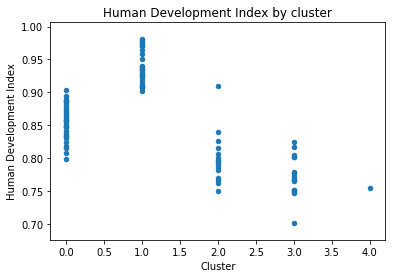

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

saoPauloDf.plot(
    kind='scatter',
    x='Cluster Labels',
    y='Human Development Index')
plt.title('Human Development Index by cluster')
plt.xlabel('Cluster')
plt.ylabel('Human Development Index')

plt.show()

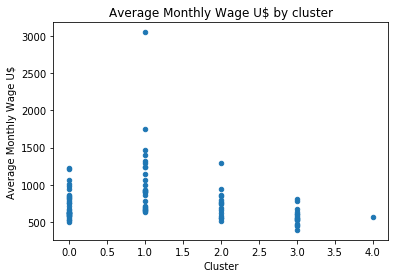

In [14]:
saoPauloDf.plot(
    kind='scatter',
    x='Cluster Labels',
    y='Average Monthly Wage U$')
plt.title('Average Monthly Wage U$ by cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Monthly Wage U$')

plt.show()

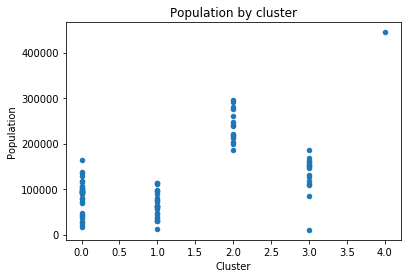

In [15]:
saoPauloDf.plot(
    kind='scatter',
    x='Cluster Labels',
    y='Population2010')
plt.title('Population by cluster')
plt.xlabel('Cluster')
plt.ylabel('Population')

plt.show()

Let us group some categories and delete categories not related to human development:

In [16]:
pd.unique(saopaulo_venues['Venue Category'])

array(['Bus Line', 'Non-Profit', 'Farm', "Dentist's Office",
       'Neighborhood', 'Music School', "Doctor's Office",
       'Elementary School', 'School', 'Gym', 'Dive Spot',
       'Medical Center', 'Martial Arts Dojo', 'Gym / Fitness Center',
       'Nursery School', 'High School', 'Athletics & Sports',
       'Driving School', 'Gymnastics Gym', 'Mountain', 'Religious School',
       'Language School', 'Playground', 'Veterinarian', 'Theme Park',
       'Library', 'Plaza', 'Field', 'Hospital', 'Middle School', 'Pool',
       'Skate Park', 'Garden', 'River', 'Emergency Room', 'Park',
       'Soccer Field', 'Bus Station', 'Rest Area', 'Other Great Outdoors',
       'Daycare', 'Castle', 'Pedestrian Plaza', 'Well', 'Private School',
       'Baseball Field', 'Cemetery', 'Nature Preserve', 'Medical Lab',
       'Metro Station', 'Spiritual Center', 'Eye Doctor', 'Pet Store',
       'Track', 'Outdoors & Recreation', 'Adult Education Center',
       'Physical Therapist', 'Gun Range', 'Bridge

In [17]:
saopaulo_venues_filtered = saopaulo_venues

sports_categories = ['Martial Arts Dojo', 'Gym / Fitness Center', 'Gym', 'Athletics & Sports',
	'Gymnastics Gym', 'Skate Park','Soccer Field', 'Swim School', 'Yoga Studio',
    'Boxing Gym', 'Badminton Court', 'Pilates Studio', 'Basketball Court','Volleyball Court',
    'Golf Course', 'Bike Trail', 'Tennis Court', 'Squash Court', 'Baseball Field',
    'Sports Club','Outdoor Gym', 'Pool', 'Gym Pool']
saopaulo_venues_filtered.loc[saopaulo_venues_filtered['Venue Category'].isin(sports_categories), ['Venue Category']] = 'Sports'

schools_categories = ['Elementary School', 'Nursery School', 'Middle School', 'Private School',  'Adult Education Center', 'General College & University',
    'Student Center', 'College & University', 'Community College', 'High School', 'University','Preschool', 'Language School'] 
saopaulo_venues_filtered.loc[saopaulo_venues_filtered['Venue Category'].isin(schools_categories), ['Venue Category']] = 'School'

health_categories = ["Doctor's Office", 'Medical Center', 'Hospital', 'Physical Therapist', 'Mental Health Office', 'Acupuncturist', 'Chiropractor',
    'Rehab Center', 'Medical Lab', 'Eye Doctor', 'Maternity Clinic', 'Urgent Care Center','Emergency Room','Urgent Care Center']
saopaulo_venues_filtered.loc[saopaulo_venues_filtered['Venue Category'].isin(health_categories), ['Venue Category']] = 'Health'

entertainment_categories= ['Music School','General Entertainment','Park', 'Recreation Center', 'Dance Studio', 'Playground', 'Outdoors & Recreation',
    'Garden', 'Botanical Garden', 'Nature Preserve']
saopaulo_venues_filtered.loc[saopaulo_venues_filtered['Venue Category'].isin(entertainment_categories), ['Venue Category']] = 'Entertainment'

bus_categories=['Bus Line', 'Bus Station']
saopaulo_venues_filtered.loc[saopaulo_venues_filtered['Venue Category'].isin(bus_categories), ['Venue Category']] = 'Bus'

final_categories=['Bus', "Dentist's Office", 'School', 'Sports', 'Entertainment', 'Health', 
    'Library', 'Daycare', 'Metro Station', 'Train Station', 'Bookstore']
saopaulo_venues_filtered = saopaulo_venues_filtered[saopaulo_venues_filtered['Venue Category'].isin(final_categories)]


And here we have the remaining categories:

In [18]:
pd.unique(saopaulo_venues_filtered['Venue Category'])

array(['Bus', "Dentist's Office", 'Entertainment', 'Health', 'School',
       'Sports', 'Library', 'Daycare', 'Metro Station', 'Train Station',
       'Bookstore'], dtype=object)

In [19]:
saopaulo_venues_filtered = saopaulo_venues_filtered.drop('District Latitude',1).drop('District Longitude', 1).drop('Venue',1).drop('Venue Latitude', 1).drop('Venue Longitude',1)


In [20]:
bus_category= saopaulo_venues_filtered.loc[saopaulo_venues_filtered["Venue Category"]=='Bus'].groupby(['District']).count().reset_index()
bus_category.rename(columns={'Venue Category':'Bus'}, inplace="True")
saoPauloDf = saoPauloDf.merge(bus_category, how='left', on="District")

dentist_category= saopaulo_venues_filtered.loc[saopaulo_venues_filtered["Venue Category"]=="Dentist's Office"].groupby(['District']).count().reset_index()
dentist_category.rename(columns={'Venue Category':'Dentist'}, inplace="True")
saoPauloDf = saoPauloDf.merge(dentist_category, how='left', on="District")

school_category= saopaulo_venues_filtered.loc[saopaulo_venues_filtered["Venue Category"]=='School'].groupby(['District']).count().reset_index()
school_category.rename(columns={'Venue Category':'School'}, inplace="True")
saoPauloDf = saoPauloDf.merge(school_category, how='left', on="District")

entertainment_category= saopaulo_venues_filtered.loc[saopaulo_venues_filtered["Venue Category"]=='Entertainment'].groupby(['District']).count().reset_index()
entertainment_category.rename(columns={'Venue Category':'Entertaiment'}, inplace="True")
saoPauloDf = saoPauloDf.merge(entertainment_category, how='left', on="District")

health_category= saopaulo_venues_filtered.loc[saopaulo_venues_filtered["Venue Category"]=='Health'].groupby(['District']).count().reset_index()
health_category.rename(columns={'Venue Category':'Health'}, inplace="True")
saoPauloDf = saoPauloDf.merge(health_category, how='left', on="District")

sports_category= saopaulo_venues_filtered.loc[saopaulo_venues_filtered["Venue Category"]=='Sports'].groupby(['District']).count().reset_index()
sports_category.rename(columns={'Venue Category':'Sports'}, inplace="True")
saoPauloDf = saoPauloDf.merge(sports_category, how='left', on="District")

library_category= saopaulo_venues_filtered.loc[saopaulo_venues_filtered["Venue Category"]=='Library'].groupby(['District']).count().reset_index()
library_category.rename(columns={'Venue Category':'Library'}, inplace="True")
saoPauloDf = saoPauloDf.merge(library_category, how='left', on="District")

daycare_category= saopaulo_venues_filtered.loc[saopaulo_venues_filtered["Venue Category"]=='Daycare'].groupby(['District']).count().reset_index()
daycare_category.rename(columns={'Venue Category':'Daycare'}, inplace="True")
saoPauloDf = saoPauloDf.merge(daycare_category, how='left', on="District")

metro_category= saopaulo_venues_filtered.loc[saopaulo_venues_filtered["Venue Category"]=='Metro Station'].groupby(['District']).count().reset_index()
metro_category.rename(columns={'Venue Category':'Metro Station'}, inplace="True")
saoPauloDf = saoPauloDf.merge(metro_category, how='left', on="District")

train_category= saopaulo_venues_filtered.loc[saopaulo_venues_filtered["Venue Category"]=='Train Station'].groupby(['District']).count().reset_index()
train_category.rename(columns={'Venue Category':'Train Station'}, inplace="True")
saoPauloDf = saoPauloDf.merge(train_category, how='left', on="District")

bookstore_category= saopaulo_venues_filtered.loc[saopaulo_venues_filtered["Venue Category"]=='Bookstore'].groupby(['District']).count().reset_index()
bookstore_category.rename(columns={'Venue Category':'Bookstore'}, inplace="True")
saoPauloDf = saoPauloDf.merge(bookstore_category, how='left', on="District")

saoPauloDf.head()


,Cluster Labels,District,Population2010,Human Development Index,Classification,Latitude,Longitude,Average Monthly Wage R$,Average Monthly Wage U$,Bus,Dentist,School,Entertaiment,Health,Sports,Library,Daycare,Metro Station,Train Station,Bookstore
0,4,Grajaú,444593,0.754,medium,-23.771911,-46.669070,1852.28,561.296970,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Sapopemba,296042,0.786,medium,-23.573739,-46.524185,2500.50,757.727273,3.0,2.0,4.0,1.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN
2,2,Jardim Ângela,291798,0.750,medium,-23.700988,-46.769102,1889.36,572.533333,NaN,1.0,2.0,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN
3,2,Brasilândia,280069,0.769,medium,-23.470400,-46.689832,1680.36,509.200000,2.0,10.0,3.0,1.0,3.0,5.0,1.0,NaN,NaN,NaN,NaN
4,2,Capão Redondo,275230,0.782,medium,-23.668870,-46.769991,2018.27,611.596970,1.0,5.0,8.0,1.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN


And here we have how many items we have in each District:

In [21]:
saoPauloDf.fillna(0, inplace=True)
saoPauloDf.head()

,Cluster Labels,District,Population2010,Human Development Index,Classification,Latitude,Longitude,Average Monthly Wage R$,Average Monthly Wage U$,Bus,Dentist,School,Entertaiment,Health,Sports,Library,Daycare,Metro Station,Train Station,Bookstore
0,4,Grajaú,444593,0.754,medium,-23.771911,-46.669070,1852.28,561.296970,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Sapopemba,296042,0.786,medium,-23.573739,-46.524185,2500.50,757.727273,3.0,2.0,4.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0
2,2,Jardim Ângela,291798,0.750,medium,-23.700988,-46.769102,1889.36,572.533333,0.0,1.0,2.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0
3,2,Brasilândia,280069,0.769,medium,-23.470400,-46.689832,1680.36,509.200000,2.0,10.0,3.0,1.0,3.0,5.0,1.0,0.0,0.0,0.0,0.0
4,2,Capão Redondo,275230,0.782,medium,-23.668870,-46.769991,2018.27,611.596970,1.0,5.0,8.0,1.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0


Plotting some graphics:

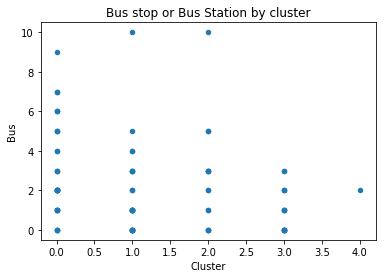

In [22]:
saoPauloDf.plot(
    kind='scatter',
    x='Cluster Labels',
    y='Bus')
plt.title('Bus stop or Bus Station by cluster')
plt.xlabel('Cluster')
plt.ylabel('Bus')

plt.show()

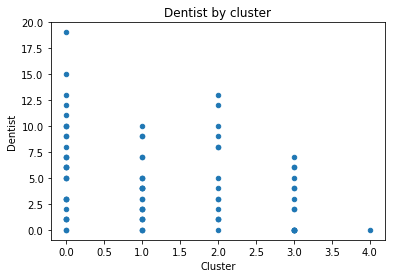

In [23]:
saoPauloDf.plot(
    kind='scatter',
    x='Cluster Labels',
    y='Dentist')
plt.title('Dentist by cluster')
plt.xlabel('Cluster')
plt.ylabel('Dentist')
plt.show()

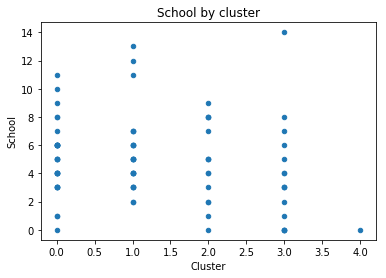

In [24]:
saoPauloDf.plot(
    kind='scatter',
    x='Cluster Labels',
    y='School')
plt.title('School by cluster')
plt.xlabel('Cluster')
plt.ylabel('School')
plt.show()

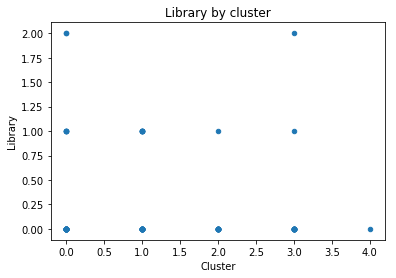

In [25]:
saoPauloDf.plot(
    kind='scatter',
    x='Cluster Labels',
    y='Library')
plt.title('Library by cluster')
plt.xlabel('Cluster')
plt.ylabel('Library')
plt.show()

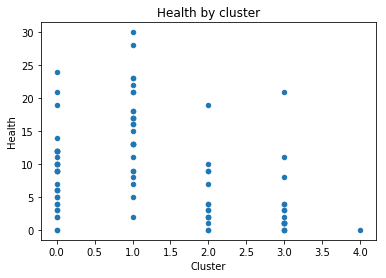

In [26]:
saoPauloDf.plot(
    kind='scatter',
    x='Cluster Labels',
    y='Health')
plt.title('Health by cluster')
plt.xlabel('Cluster')
plt.ylabel('Health')
plt.show()

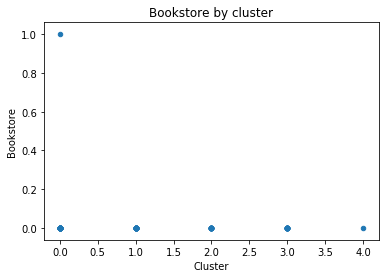

In [27]:
saoPauloDf.plot(
    kind='scatter',
    x='Cluster Labels',
    y='Bookstore')
plt.title('Bookstore by cluster')
plt.xlabel('Cluster')
plt.ylabel('Bookstore')
plt.show()

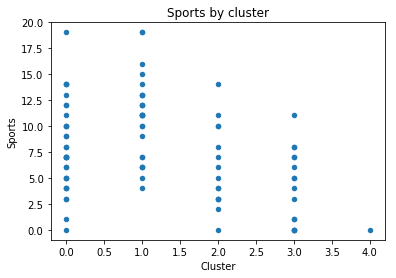

In [28]:
saoPauloDf.plot(
    kind='scatter',
    x='Cluster Labels',
    y='Sports')
plt.title('Sports by cluster')
plt.xlabel('Cluster')
plt.ylabel('Sports')
plt.show()

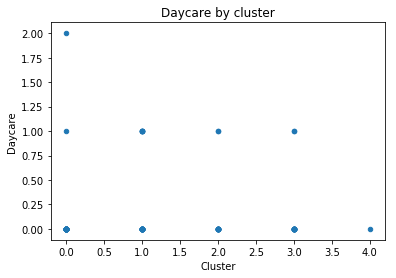

In [29]:
saoPauloDf.plot(
    kind='scatter',
    x='Cluster Labels',
    y='Daycare')
plt.title('Daycare by cluster')
plt.xlabel('Cluster')
plt.ylabel('Daycare')
plt.show()

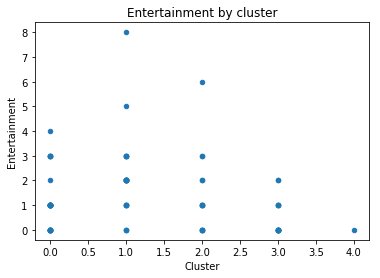

In [30]:
saoPauloDf.plot(
    kind='scatter',
    x='Cluster Labels',
    y='Entertaiment')
plt.title('Entertainment by cluster')
plt.xlabel('Cluster')
plt.ylabel('Entertainment')
plt.show()

In [31]:
saoPauloDf['Total']=saoPauloDf.iloc[:,-11:].sum(axis=1)

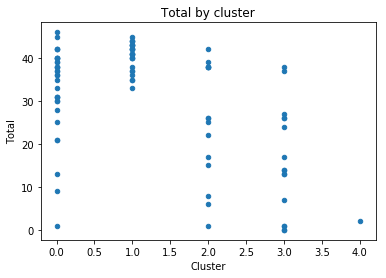

In [32]:
saoPauloDf.plot(
    kind='scatter',
    x='Cluster Labels',
    y='Total')
plt.title('Total by cluster')
plt.xlabel('Cluster')
plt.ylabel('Total')
plt.show()

In [33]:
saoPauloDf.head()

,Cluster Labels,District,Population2010,Human Development Index,Classification,Latitude,Longitude,Average Monthly Wage R$,Average Monthly Wage U$,Bus,Dentist,School,Entertaiment,Health,Sports,Library,Daycare,Metro Station,Train Station,Bookstore,Total
0,4,Grajaú,444593,0.754,medium,-23.771911,-46.669070,1852.28,561.296970,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,2,Sapopemba,296042,0.786,medium,-23.573739,-46.524185,2500.50,757.727273,3.0,2.0,4.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,15.0
2,2,Jardim Ângela,291798,0.750,medium,-23.700988,-46.769102,1889.36,572.533333,0.0,1.0,2.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,8.0
3,2,Brasilândia,280069,0.769,medium,-23.470400,-46.689832,1680.36,509.200000,2.0,10.0,3.0,1.0,3.0,5.0,1.0,0.0,0.0,0.0,0.0,25.0
4,2,Capão Redondo,275230,0.782,medium,-23.668870,-46.769991,2018.27,611.596970,1.0,5.0,8.0,1.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,26.0


In [34]:

saoPauloDfClustering = saoPauloDf.drop('District',1).drop('Cluster Labels',1).drop('Latitude',1).drop('Classification',1).drop('Longitude',1).drop('Average Monthly Wage R$',1).drop('Total',1)

#normalize
saoPauloDfClustering = StandardScaler().fit_transform(saoPauloDfClustering)

kclusters = 5
# run k-means clustering
kmeans3 = KMeans(n_clusters=kclusters, random_state=0).fit(saoPauloDfClustering)
# check cluster labels generated for each row in the dataframe


saoPauloDf.insert(0, 'Cluster Labels 2', kmeans3.labels_)

map_clusters3 = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(saoPauloDf['Latitude'], 
saoPauloDf['Longitude'], saoPauloDf['District'], 
saoPauloDf['Cluster Labels 2']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters3)
       
map_clusters3

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [35]:
saoPauloDf.head()

,Cluster Labels 2,Cluster Labels,District,Population2010,Human Development Index,Classification,Latitude,Longitude,Average Monthly Wage R$,Average Monthly Wage U$,Bus,Dentist,School,Entertaiment,Health,Sports,Library,Daycare,Metro Station,Train Station,Bookstore,Total
0,4,4,Grajaú,444593,0.754,medium,-23.771911,-46.669070,1852.28,561.296970,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,4,2,Sapopemba,296042,0.786,medium,-23.573739,-46.524185,2500.50,757.727273,3.0,2.0,4.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,15.0
2,4,2,Jardim Ângela,291798,0.750,medium,-23.700988,-46.769102,1889.36,572.533333,0.0,1.0,2.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,8.0
3,4,2,Brasilândia,280069,0.769,medium,-23.470400,-46.689832,1680.36,509.200000,2.0,10.0,3.0,1.0,3.0,5.0,1.0,0.0,0.0,0.0,0.0,25.0
4,4,2,Capão Redondo,275230,0.782,medium,-23.668870,-46.769991,2018.27,611.596970,1.0,5.0,8.0,1.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,26.0


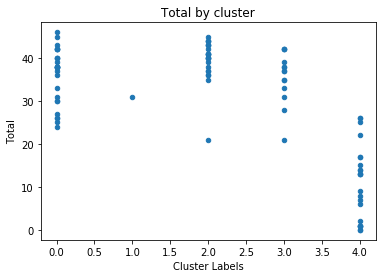

In [36]:
saoPauloDf.plot(
    kind='scatter',
    x='Cluster Labels 2',
    y='Total')
plt.title('Total by cluster')
plt.xlabel('Cluster Labels')
plt.ylabel('Total')
plt.show()

In [37]:
saoPauloDf.loc[saoPauloDf['Cluster Labels'] == 4]

,Cluster Labels 2,Cluster Labels,District,Population2010,Human Development Index,Classification,Latitude,Longitude,Average Monthly Wage R$,Average Monthly Wage U$,Bus,Dentist,School,Entertaiment,Health,Sports,Library,Daycare,Metro Station,Train Station,Bookstore,Total
0,4,4,Grajaú,444593,0.754,medium,-23.771911,-46.66907,1852.28,561.29697,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


The number of the cluster have changed from 3 to 4 since last ex

In [41]:
saoPauloDf.loc[saoPauloDf['Cluster Labels 2'] == 4]

,Cluster Labels 2,Cluster Labels,District,Population2010,Human Development Index,Classification,Latitude,Longitude,Average Monthly Wage R$,Average Monthly Wage U$,Bus,Dentist,School,Entertaiment,Health,Sports,Library,Daycare,Metro Station,Train Station,Bookstore,Total
0,4,4,Grajaú,444593,0.754,medium,-23.771911,-46.669070,1852.28,561.296970,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,4,2,Sapopemba,296042,0.786,medium,-23.573739,-46.524185,2500.50,757.727273,3.0,2.0,4.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,15.0
2,4,2,Jardim Ângela,291798,0.750,medium,-23.700988,-46.769102,1889.36,572.533333,0.0,1.0,2.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,8.0
3,4,2,Brasilândia,280069,0.769,medium,-23.470400,-46.689832,1680.36,509.200000,2.0,10.0,3.0,1.0,3.0,5.0,1.0,0.0,0.0,0.0,0.0,25.0
4,4,2,Capão Redondo,275230,0.782,medium,-23.668870,-46.769991,2018.27,611.596970,1.0,5.0,8.0,1.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,26.0
7,4,2,Itaim Paulista,241026,0.762,medium,-23.469455,-46.405854,2520.70,763.848485,2.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0
9,4,2,Jaraguá,220292,0.791,medium,-23.439354,-46.782427,2783.40,843.454545,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10,4,2,Cidade Tiradentes,219868,0.766,medium,-23.601429,-46.398844,4252.35,1288.590909,5.0,3.0,2.0,0.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,17.0
11,4,2,Campo Limpo,216098,0.806,high,-23.634547,-46.754958,1801.48,545.903030,0.0,3.0,4.0,3.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,22.0
16,4,3,Lajeado,185184,0.748,medium,-23.526313,-46.429817,1470.31,445.548485,2.0,3.0,4.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,13.0


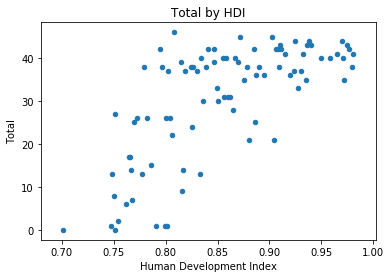

In [39]:
saoPauloDf.plot(
    kind='scatter',
    x='Human Development Index',
    y='Total')
plt.title('Total by HDI')
plt.xlabel('Human Development Index')
plt.ylabel('Total')
plt.show()